# Курсовий проект. Тема "Перегляд реклами"
* Метою цього проєкту є аналіз ефективності показу онлайн-реклами. 
* Основнa задача: Побудова моделі для прогнозування кількості переглядів залежно від часу, типу реклами та інших параметрів.

**Завдання**
1. **EDA (Exploratory Data Analysis)**:
   - Проаналізуйте дані на наявність трендів, сезонності та аномалій.   
   - Візуалізуйте дані (часові графіки, гістограми, теплові карти тощо).  

2. **Попередня обробка**:
   - Врахуйте аномалії у даних: визначте, чи потрібно їх видалити, згладити або моделювати окремо.

3. **Прогнозування**:
   - Використовуйте оброблені дані для створення моделі прогнозування на 7 днів наперед.  
   - Виберіть модель, яка враховує тренди та сезонність (наприклад, ARIMA, Prophet або LSTM).  

4. **Оцінка результатів**:
   - Перевірте якість прогнозу, використовуючи метрики (наприклад, RMSE, MAE).  
   - Інтерпретуйте отриманий прогноз і перевірте, як модель справляється з аномаліями.
  
Дані: набір містить інформацію про кількість перегрлядів реклами під час комп'ютерної гри. Дані агреговані погодинно.

# Виконання

In [5]:
import pandas as pd
data = pd.read_csv('data/ads.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
data.head()


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


<Axes: xlabel='Time'>

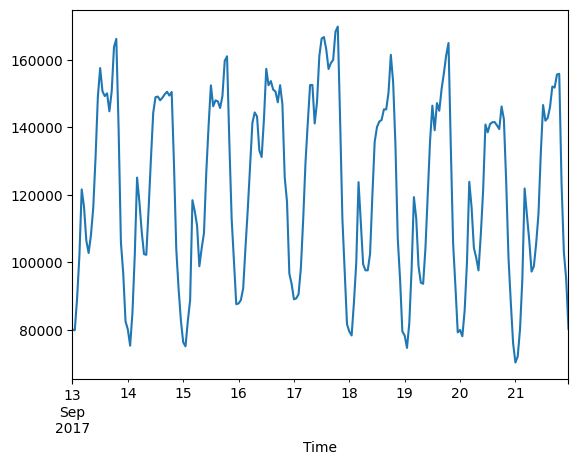

In [6]:
data['Ads'].plot()